In [14]:
#Import Iibraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from scipy.stats import entropy

In [15]:
total_encoded_values = 0
max_code_value = 0
total_encoded_bits = 0

In [16]:
dictionary = {}
for i in range(256):
    dictionary[str(i)] = i

In [17]:
''' Encoder '''

def encode(data,codeSize):
    
    # Building and initializing the dictionary.
    dictionary_size = 256                   
    dictionary = {chr(i): i for i in range(dictionary_size)}    
    string = ""             # String is null.
    compressed_data = []    # variable to store the compressed data.
    
    for symbol in data:  
        # print(int(symbol))                
        symbol = chr(int(symbol))   
        string_plus_symbol = string + symbol # get input symbol.
        if string_plus_symbol in dictionary: 
            string = string_plus_symbol
        else:
            compressed_data.append(dictionary[string])
            if(len(dictionary) < codeSize):
                dictionary[string_plus_symbol] = dictionary_size
                dictionary_size += 1
            string = symbol

    if string in dictionary:
        compressed_data.append(dictionary[string])
    # print(dictionary)
    return compressed_data

def LZW_encoder(filename,blockSize,codeSize):
    
    #Read the image
    image = cv2.imread(filename)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # print(img.shape)
    #BlockSize
    n1=0
    n2=0
    if(blockSize == -1):
        n1 = img.shape[0]
        n2 = img.shape[1]
    else:
        n1 = blockSize
        n2 = blockSize
    
    #padding
    height,width = img.shape
    pad_h = height % n1
    pad_w = width % n2

    if(pad_h != 0):
        pad_h = n1 - pad_h
        lst = []
        for i in range(pad_h):
            lst2 = []
            for j in range(width):
                lst2.append(0)
            lst.append(lst2)

        img = np.append(img,lst,axis=0)

    if(pad_w != 0):
        pad_w = n2 - pad_w
        newHeight = img.shape[0]
        zeros = np.zeros((newHeight,pad_w),dtype=int)
        img = np.hstack((img,zeros))
    
    # print(img.shape)
    # print(img.shape[1])
    
    # blockSize1 = blockSize
    # blockSize2 = blockSize
    # if(blockSize == -1):
    #     blockSize1 = img.shape[0]
    #     blockSize2 = img.shape[1]

    array = []
    count = 0
    i = 0
    while i<img.shape[0]:
        j = 0
        while j<img.shape[1]:
            lst = []
            for k in range(n1):
                for l in range(n2):
                    lst.append(str(img[i+k][j+l]))
            # array.append(encode(lst))
            # print(lst)
            array.append(encode(lst,codeSize))
            j += n2
        i += n1
    
    global total_encoded_values
    global total_encoded_bits
    global max_code_value
    file = open('lzw_encoded.txt','w')
    file.write(str(img.shape[0])+" ")
    file.write(str(img.shape[1])+" ")
    file.write(str(blockSize)+"\n")
    for i in range(len(array)):
        for values in array[i]:
            total_encoded_values += 1
            max_code_value = max(max_code_value,values)
            total_encoded_bits += values.bit_length()
            file.write(str(values)+" ")
        file.write("\n")
    file.close()


In [18]:
''' DECODER '''

def decode(compressed_data):
    dictionary = {}
    for i in range(256):
        dictionary[i] = chr(i)
    
    next_code = 256
    decompressed_data = ""
    string = ""
    for code in compressed_data:
        code = int(code)
        if not (code in dictionary):
            dictionary[code] = string + (string[0])
        decompressed_data += dictionary[code]
        if not(len(string) == 0):
            dictionary[next_code] = string + (dictionary[code][0])
            next_code += 1
        string = dictionary[code]
    return decompressed_data

def LZW_decoder(filename):
    file = open(filename,'r')
    height,width,blockSize = [int(x) for x in next(file).split()]
    array = []
    for line in file:
        array.append(line.strip('\n').strip(' ').split(' '))
        
    result = []
    for i in range(len(array)):
        decodedString = decode(array[i])
        decodedVector = []
        for ch in decodedString:
            decodedVector.append(ord(ch))
        result.append(decodedVector)
        
    # for i in range(len(result)):
    #     if(len(result[i]) != 64):
    #         print(f"{i} {len(result[i])}")
    
    # print(height)
    # print(width)
    decodedImg = np.zeros([height,width],dtype=int)
    #BlockSize
    n1=0
    n2=0
    if(blockSize == -1):
        n1 = height
        n2 = width
    else:
        n1 = blockSize
        n2 = blockSize
    
    pad_h = height % n1
    pad_w = width % n2
    
    if(pad_h!=0):
        pad_h = n1-pad_h
        lst = []
        for i in range(pad_h):
            lst2 = []
            for j in range(decodedImg.shape[1]):
                lst2.append(0)
            lst.append(lst2)
        decodedImg = np.append(decodedImg,lst,axis=0)
        
    if(pad_w!=0):
        pad_w = n2-pad_w
        newHeight = decodedImg.shape[0]
        zeros = np.zeros((newHeight,pad_w),dtype=int)
        decodedImg = np.hstack((decodedImg,zeros))
        
    # n = math.sqrt(len(result[0]))
    # n = int(n)
    x = decodedImg.shape[0]//n1
    y = decodedImg.shape[1]//n2
    # print(x)
    # print(y)
    start = 0
    s = 0
    for i in range(x):
        c = 0
        for j in range(y):
            lst = result[start + j]
            lst = np.array(lst)
            lst = lst.reshape(n1,n2)
            for k in range(n1):
                for l in range(n2):
                    decodedImg[s+k][c+l] = lst[k][l]
            c = c + n2
        start = start + y
        s = s + n1
    
    
    decodedImg = np.array(decodedImg).astype(np.uint8)
    
    return decodedImg



In [19]:
'''
                    CHANGE THE FILENAME, BLOCKSIZE, CODESIZE HERE
'''

filename = 'fingerprint.tif'
blockSize = 8
codeSize = 4096
LZW_encoder(filename,blockSize,codeSize)

In [20]:
filename1 = 'lzw_encoded.txt'
decodedImg = LZW_decoder(filename1)
# plt.imshow(decodedImg,cmap='gray')

img = cv2.imread(filename)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
size = decodedImg.shape
decodedImg = decodedImg[0:img.shape[0],0:img.shape[1]]

# STATS:

1. IMAGE PLOTS

Text(0.5, 1.0, 'Decoded Image')

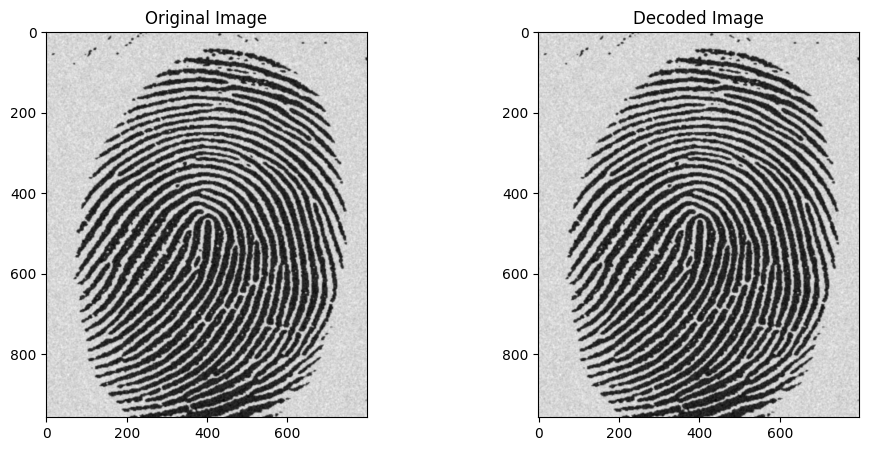

In [21]:
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(img,cmap='gray'); plt.title('Original Image')
plt.subplot(132); plt.imshow(decodedImg,cmap='gray'); plt.title('Decoded Image')

2. RMSE ERROR

In [22]:
difference = img - decodedImg
sq_diff = difference ** 2
mean_sq_diff = sq_diff.mean()
rmse = np.sqrt(mean_sq_diff)
print(rmse)

0.0


3. COMPRESSION RATIO

In [23]:
compression_ratio = (size[0]*size[1]*8)/(total_encoded_bits)
print(compression_ratio)

1.3711745368603585


4. ENTROPY

In [24]:
# hist = cv2.calcHist([img],[0],None,[256],[0,256])
# normalize_hist = cv2.normalize(hist,None).flatten()
# entropy = -np.sum(normalize_hist * np.log2(normalize_hist + 1e-8))
# print(entropy)

_bins = 256
hist, _ = np.histogram(img.ravel(), bins=_bins, range=(0, _bins))
prob_dist = hist / hist.sum()
image_entropy = entropy(prob_dist, base=2)
print(image_entropy)

6.56790603015178


5. MAXIMUM CODE VALUE USED

In [25]:
print(max_code_value)

304


6. MAXIMUM COMPRESSION ACHIEVED

In [26]:
max_compression = 8/image_entropy
print(max_compression)

1.2180442234212545
